# INTRODUCCIÓN AL APRENDIZAJE AUTOMÁTICO
## LABORATORIO 1
### FERRARO, MARÍA EUGENIA

In [4]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib as mp

from matplotlib.colors import ListedColormap
from sklearn.datasets import load_boston, load_breast_cancer, load_iris
from sklearn.linear_model import LinearRegression, LogisticRegression, Perceptron, Ridge
from sklearn.metrics import accuracy_score, confusion_matrix, mean_squared_error
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import PolynomialFeatures

from ml.visualization import plot_confusion_matrix, classifier_boundary

np.random.seed(1234)  # Setup seed to be more deterministic\n",


import pandas as pd
import seaborn as sb


%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

# REGRESION

In [29]:
def regresion_lineal(xtf,yt,xvf,yv,regularizacion,alpha,feature):
    if regularizacion==False:
        model = LinearRegression()
        model.fit(xtf, yt)
    else:
        model = Ridge(alpha=alpha)
        model.fit(xtf, yt)
 
    err_train = mean_squared_error(yt, model.predict(xtf))
    err_val = mean_squared_error(yv, model.predict(xvf)) 
        
    return [feature,regularizacion,alpha,err_train,err_val,model.coef_,model.intercept_]


def regresion_polinomial(xtf,yt,xvf,yv,grado_polinomio,regularizacion,alpha,feature):
    poly_features = PolynomialFeatures(grado_polinomio)
    poly_features.fit(xtf)
    X_poly_train = poly_features.transform(xtf)
    X_poly_val = poly_features.transform(xvf)
    
    if regularizacion==False:
        model = LinearRegression()
        model.fit(X_poly_train, y_train)

    else:
        model = Ridge(alpha=alpha)
        model.fit(X_poly_train, y_train)        

    err_train = mean_squared_error(y_train, model.predict(X_poly_train))
    err_val = mean_squared_error(y_val, model.predict(X_poly_val))
    
    return [feature,grado_polinomio,regularizacion,alpha,err_train,err_val,model.coef_,model.intercept_]


def modelo(x,coef,x0):
    ymodel = np.zeros(len(x))
    for i in range(len(x)):
        if len(coef)==1:
            ymodel[i] = coef[0]*x[i]
        else:
            for c in range(len(coef)):
                ymodel[i] = ymodel[i] + coef[c]*x[i]**c
    return ymodel+x0


def plot_fit(feature_resultados,tipo,c,lw):    
    X_range_start = np.min(np.r_[X_train_feature, X_val_feature])
    X_range_stop = np.max(np.r_[X_train_feature, X_val_feature])
    y_range_start = np.min(np.r_[y_train, y_val])
    y_range_stop = np.max(np.r_[y_train, y_val])

    X_linspace = np.linspace(X_range_start, X_range_stop, 200)
    
    # Conjunto de entrenamiento
    plt.scatter(X_train_feature, y_train, facecolor="lightgray", edgecolor="gray", label="datos",s=4.8)
    if tipo=='L':
        for j in range(len(feature_resultados)):
            coef = feature_resultados.Coef.values[j]
            x0 = feature_resultados.Intercept.values[j]
            plt.plot(X_linspace, modelo(X_linspace,coef,x0), color=c, label="modelo",lw=lw)
    elif tipo=='P':
        grados_= feature_resultados.Degree.unique()
        cc=0
        for g in grados_:
            sub_df = feature_resultados[feature_resultados.Degree==g]
            for j in range(len(sub_df)):
                coef = sub_df.Coef.values[j]
                x0 = sub_df.Intercept.values[j]
                plt.plot(X_linspace, modelo(X_linspace,coef,x0),color=c[cc],label="modelo",lw=1)
            cc+=1
            
    plt.ylim(y_range_start, y_range_stop)
    
    # Conjunto de validación
    #plt.subplot(1, 2, 2)
    #plt.scatter(X_val_feature, y_val, facecolor=\"dodgerblue\", edgecolor=\"k\", label=\"datos\")
    #plt.plot(X_linspace, model.predict(X_linspace_poly), color=\"tomato\", label=\"modelo\")
    #plt.ylim(y_range_start, y_range_stop)
    #plt.title(\"Conjunto de Validación\")
    
def plot_err(feature_resultados,Err,tipo,c):
    if tipo=='P':
        grados_= feature_resultados.Degree.unique()
        cc=0
        for g in grados_:
            sub_df = feature_resultados[feature_resultados.Degree==g]
            if Err=='T':
                plt.plot(sub_df.Alpha,sub_df.TrainMSE,color=c[cc],label='Grado: '+str(g))
            elif Err=='V':
                plt.plot(sub_df.Alpha,sub_df.ValMSE,color=c[cc],label='Grado: '+str(g))
            cc+=1                
        plt.legend(loc='lower right',frameon=False,ncol=3)
    elif tipo=='L':
        if Err=='T':
            plt.plot(feature_resultados.Alpha,feature_resultados.TrainMSE,color=c)
        elif Err=='V':
            plt.plot(feature_resultados.Alpha,feature_resultados.ValMSE,color=c)
    plt.xlabel('alpha')
    plt.ylabel('ECM')
    
def plot_err_g(feature_resultados,Err,c):
    if Err=='T':
        plt.plot(feature_resultados.Degree,feature_resultados.TrainMSE,color=c,label='ENTRENAMIENTO')              
    elif Err=='V':
        plt.plot(feature_resultados.Degree,feature_resultados.ValMSE,color=c,label='VALIDACION',ls='--')
    plt.xlabel('Degree')
    plt.ylabel('ECM')
    plt.legend(frameon=False,loc='upper left')

In [26]:
boston_data = load_boston()

In [27]:
regresion_lineal_ECM = pd.DataFrame(columns=['Feature','Regularization','Alpha','TrainMSE', 'ValMSE','Coef','Intercept'])
regresion_polinomial_ECM = pd.DataFrame(columns=['Feature','Degree','Regularization','Alpha','TrainMSE','ValMSE','Coef','Intercept'])


shuff_data = np.random.permutation(506)
shuff_train = shuff_data[:400]
shuff_val = shuff_data[400:]

X_train = boston_data['data'][shuff_train]
X_val = boston_data['data'][shuff_val]

y_train = boston_data['target'][shuff_train]
y_val = boston_data['target'][shuff_val]

feature_map = {feature: idx for idx, feature in enumerate(boston_data['feature_names'])}

features = boston_data['feature_names']
categorical_features = ['CHAS','RAD','MEDV']
non_categorical_features = set(features)-set(categorical_features)

#alpha = np.arange(0.1, 1.1, 0.1)
grado = np.arange(1,10,1)
alpha = np.arange(1e-5,1e3,10)

cmap = mp.cm.get_cmap('Spectral')
color = []
for i in range(len(grado)):
    color.append(cmap(0.1*i))

for feature in non_categorical_features:
    feature_col = feature_map[feature]
    X_train_feature = X_train[:, feature_col].reshape(-1, 1)
    X_val_feature = X_val[:, feature_col].reshape(-1, 1)   

    # regresion lineal
    ## sin regularizacion
    row = regresion_lineal(X_train_feature,y_train,X_val_feature,y_val,False,0,feature)
    
    regresion_lineal_ECM = regresion_lineal_ECM.append(pd.Series(row, index=regresion_lineal_ECM.columns ),ignore_index=True)
    ## con regularizacion
    for i in alpha:
        row = regresion_lineal(X_train_feature,y_train,X_val_feature,y_val,True,i,feature)
        regresion_lineal_ECM = regresion_lineal_ECM.append(pd.Series(row, index=regresion_lineal_ECM.columns ),ignore_index=True)
    

    # regresion polinomial
    ## sin regularizacion
    for g in grado:
        row = regresion_polinomial(X_train_feature,y_train,X_val_feature,y_val,g,False,0,feature)
        regresion_polinomial_ECM = regresion_polinomial_ECM.append(pd.Series(row, index=regresion_polinomial_ECM.columns ),ignore_index=True)
    ## con regularizacion
        for i in alpha:
            row = regresion_polinomial(X_train_feature,y_train,X_val_feature,y_val,g,True,i,feature)
            regresion_polinomial_ECM = regresion_polinomial_ECM.append(pd.Series(row, index=regresion_polinomial_ECM.columns ),ignore_index=True)
  

A continuación se exponen gráficos de regresón lineal con y sin regularización, de polinomios de distintos grados, para cada una de las variables no categóricas del dataset. A su vez se muestra la evolución del error cuadrático medio del conjunto de entrenamiento y del de validación, en función del grado del polinomio. 
Por otro lado se muestra, en color verde agua, que los distintos métodos, ya sea polynomial feature o la regresión directa sin pasar por el método anterior, llevan al mismo resultado cuando se trata de ajustar una recta. El punto verde agua representa el error cuando se hace la regresión directa, para un polinomio de grado 1, y la recta verde agua ancha, representa el resultado de dicho método. El resto de las curvas se corresponden con resultados de pasar primero por polynomial features y luego por la regresión.

PTRATIO


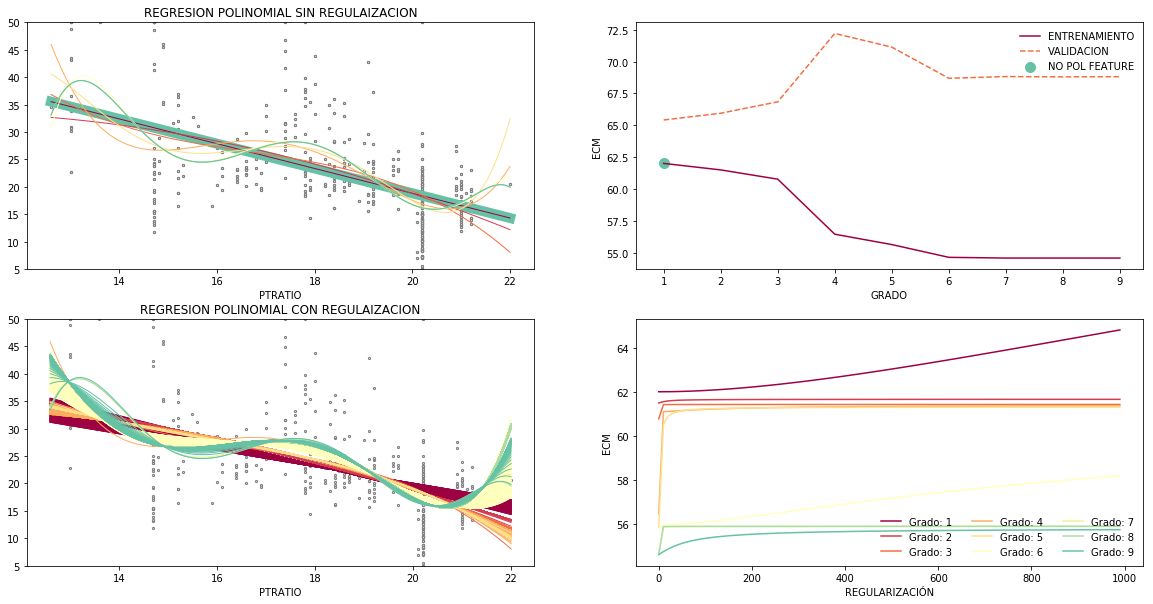

RM


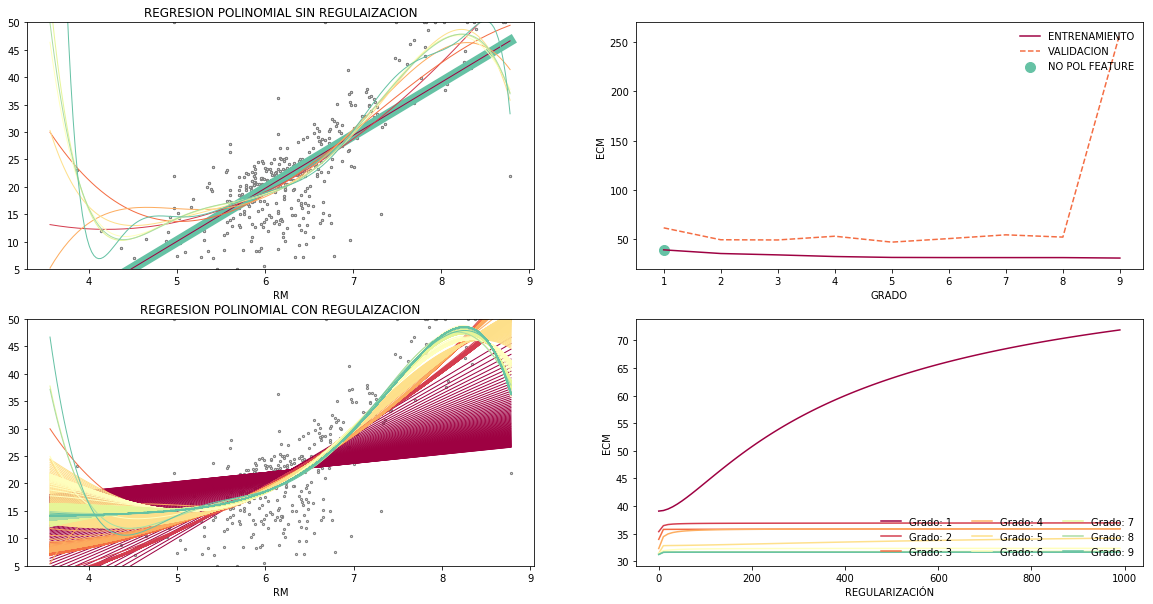

AGE


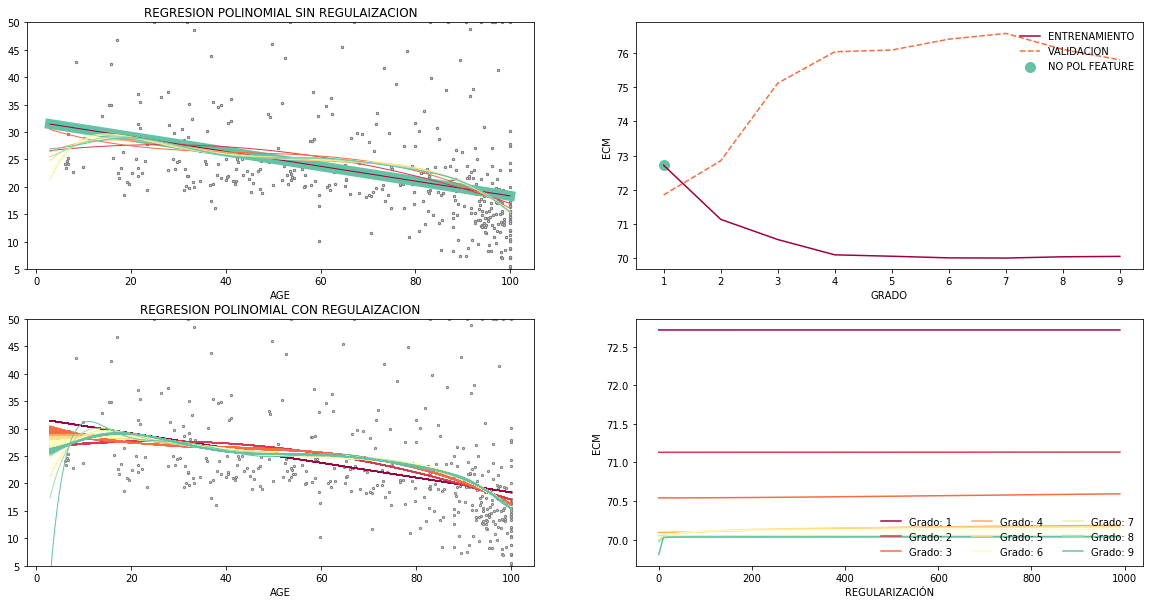

NOX


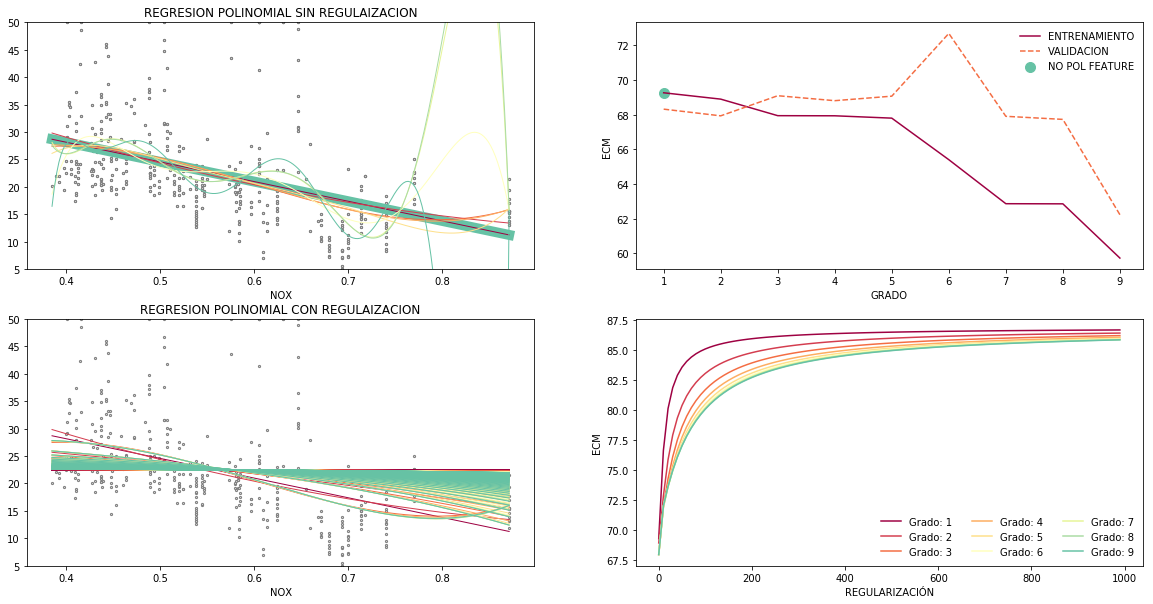

ZN


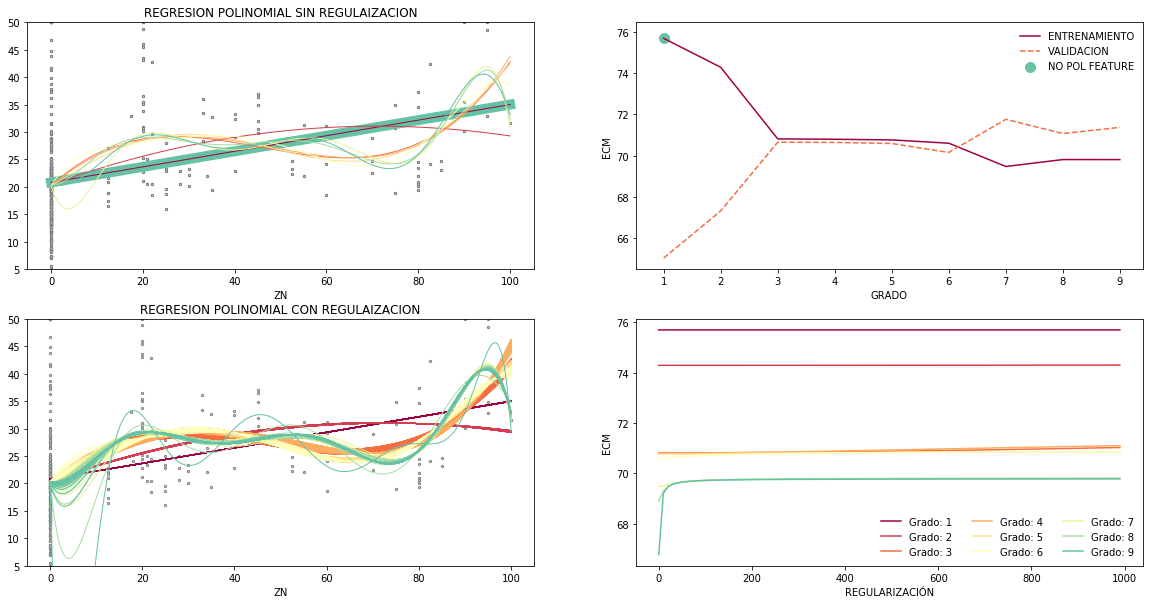

B


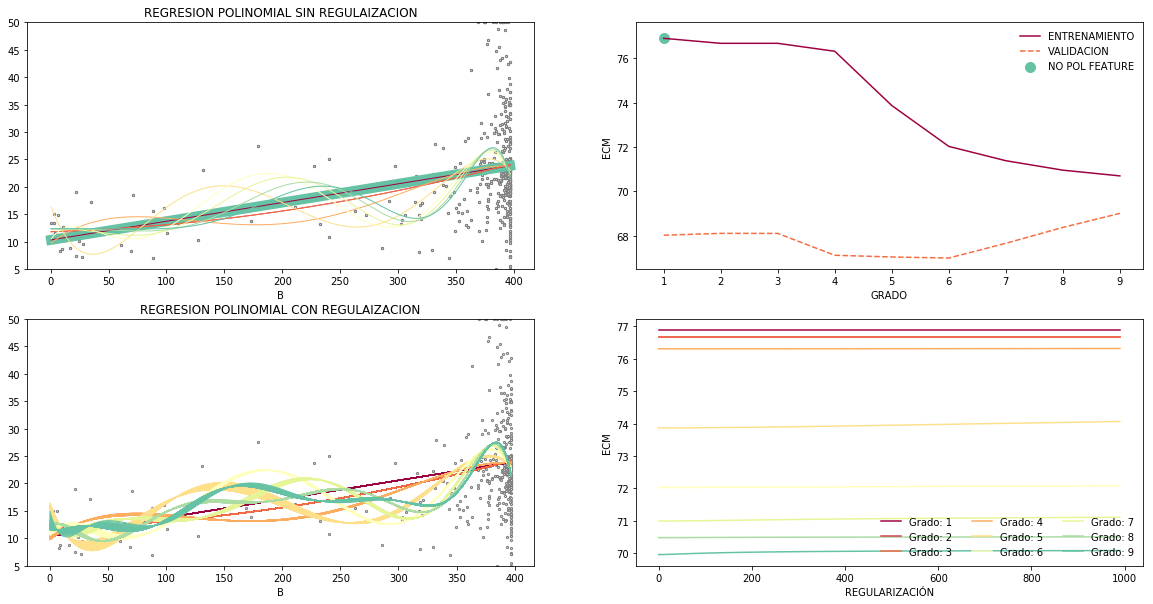

INDUS


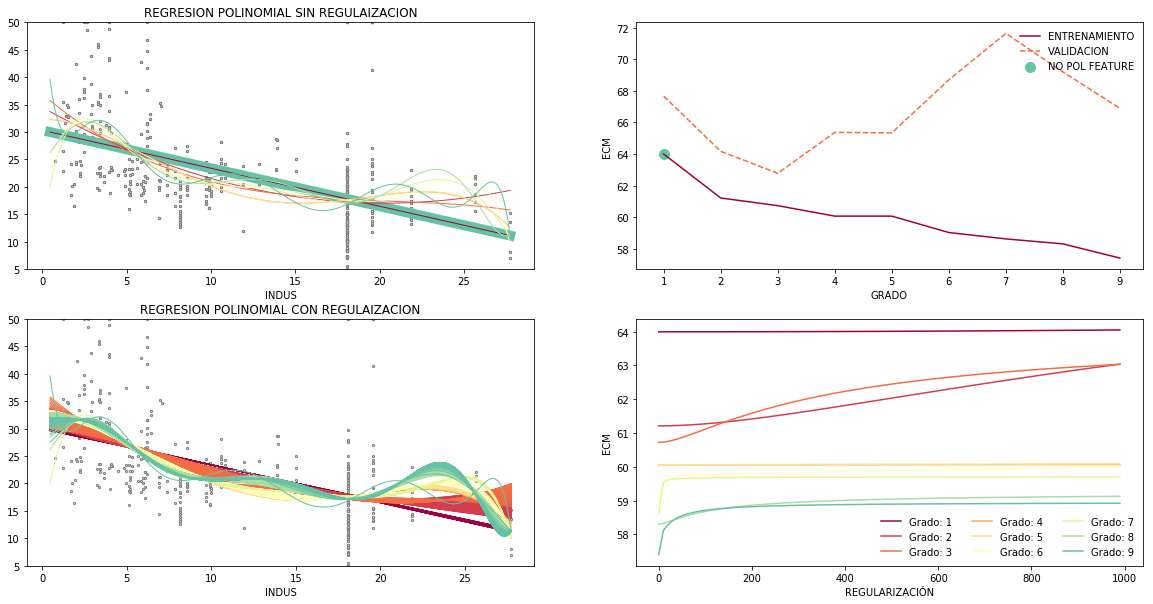

LSTAT


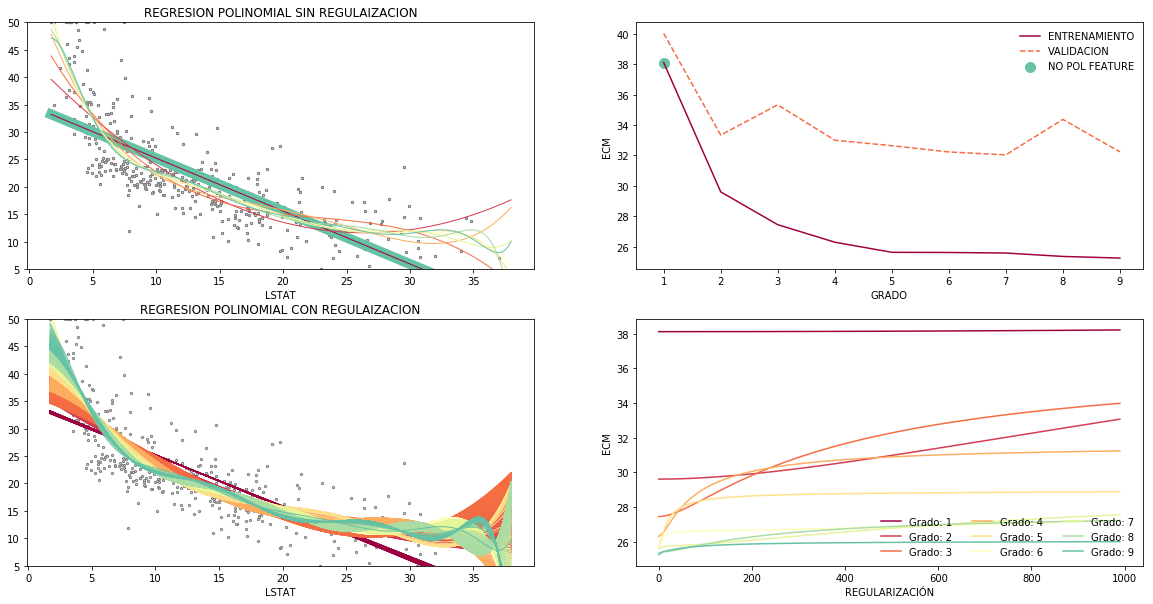

TAX


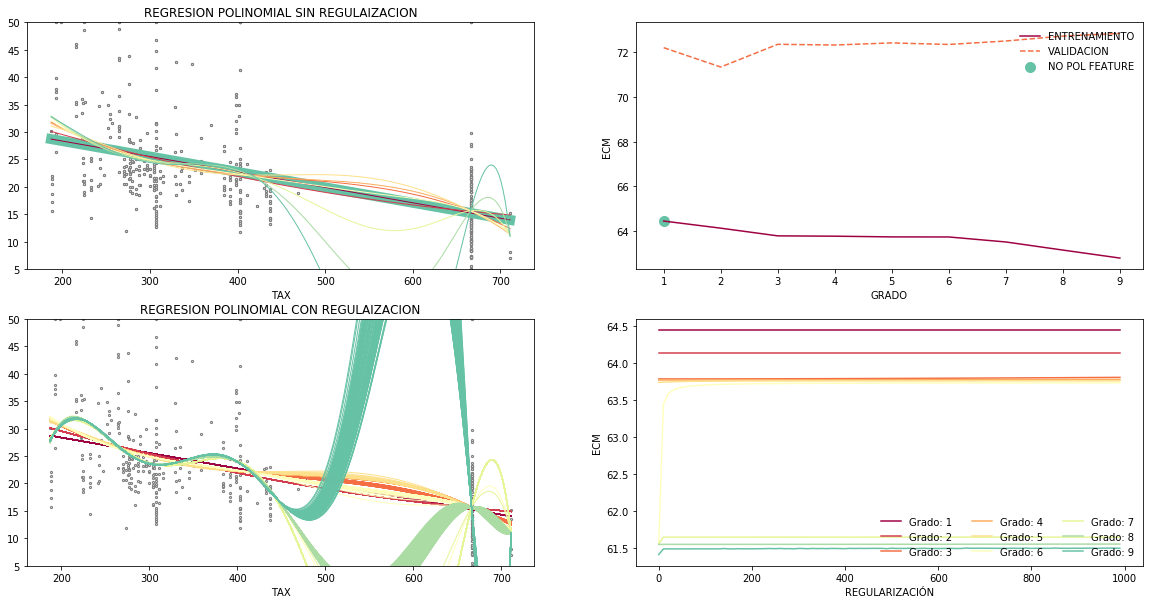

CRIM


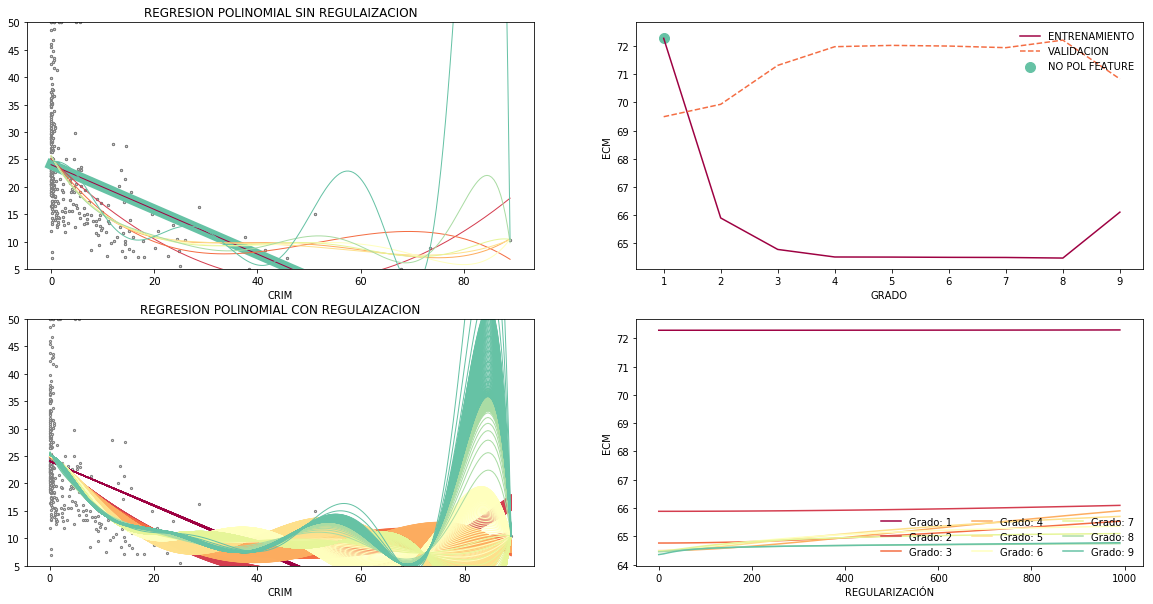

DIS


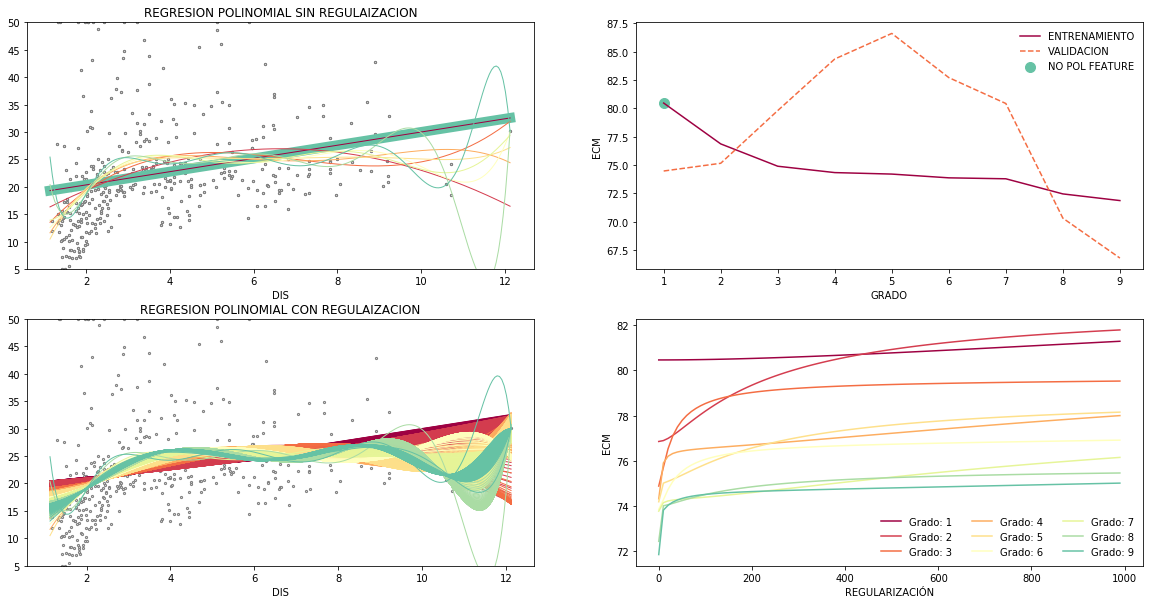

In [31]:
diferencias=[]
for feature in non_categorical_features:
    print(feature)
    feature_col = feature_map[feature]
    X_train_feature = X_train[:, feature_col].reshape(-1, 1)
    X_val_feature = X_val[:, feature_col].reshape(-1, 1)   

    plt.figure(figsize=(20,10))
    
    feature_resultadosl = regresion_lineal_ECM[(regresion_lineal_ECM.Feature==feature)&
                                               (regresion_lineal_ECM.Regularization==False)]
    punto_err_metodo_lineal = [1,feature_resultadosl.TrainMSE.values[0]]
    
    #plt.subplot(421)
    
    feature_resultados = regresion_polinomial_ECM[(regresion_polinomial_ECM.Feature==feature)&
                                                 (regresion_polinomial_ECM.Regularization==False)]
    plt.subplot(221)
    plot_fit(feature_resultadosl,'L',color[-1],lw=10)
    plot_fit(feature_resultados,'P',color,lw=1)
    plt.xlabel(feature)
    plt.title('REGRESION POLINOMIAL SIN REGULAIZACION')
    
    feature_resultados = regresion_polinomial_ECM[(regresion_polinomial_ECM.Alpha==0)&
                                                  (regresion_polinomial_ECM.Feature==feature)]

    diferencias.append(punto_err_metodo_lineal[1]-feature_resultados.TrainMSE.values[0])
    
    plt.subplot(222)
    plot_err_g(feature_resultados,'T',color[0])
    plot_err_g(feature_resultados,'V',color[2])
    plt.scatter(punto_err_metodo_lineal[0],punto_err_metodo_lineal[1],color=color[-1],s=100,label='NO POL FEATURE')
    plt.legend(frameon=False,loc='upper right')
    plt.xlabel('GRADO')
    
    
    feature_resultados = regresion_lineal_ECM[(regresion_lineal_ECM.Feature==feature)&
                                             (regresion_lineal_ECM.Regularization==True)]
    
    #plt.subplot(323)
    #plot_fit(feature_resultados,'L',color[0],lw=1)
    #plt.subplot(324)
    #plot_err(feature_resultados,'L',color[0])
    
    feature_resultados = regresion_polinomial_ECM[(regresion_polinomial_ECM.Feature==feature)&
                                                 (regresion_polinomial_ECM.Regularization==True)]
    plt.subplot(223)
    plot_fit(feature_resultados,'P',color,lw=1)
    plt.xlabel(feature)
    plt.title('REGRESION POLINOMIAL CON REGULAIZACION')
    plt.subplot(224)
    plot_err(feature_resultados,'T','P',color)
    plt.xlabel('REGULARIZACIÓN')
    #plot_err(feature_resultados,'V','P',color)
    
    
    plt.show()

A grandes rasgos se observa:
1. el error por lo general disminuye a medida que aumenta el grado
2. a medida que el grado aumenta, se observa como el overfitting genera grandes amplitudes
3. para grados grandes la regularización no es buena
4. el error en función de la regularización disminuye mientras el grado crece y crece mientras el valor de alpha (lambda en la teoría) crece

# CLASIFICACION BINARIA

In [25]:
breast_cancer_data = load_breast_cancer()

In [26]:
# Utilizamos aproximadamente 80% de los datos para entrenamiento y 20% para validación
shuff_data = np.random.permutation(569)
shuff_train = shuff_data[:400]
shuff_val = shuff_data[400:]

X_train = breast_cancer_data['data'][shuff_train]
X_val = breast_cancer_data['data'][shuff_val]

y_train = breast_cancer_data['target'][shuff_train]
y_val = breast_cancer_data['target'][shuff_val]


data = pd.DataFrame(breast_cancer_data['data'],columns=breast_cancer_data['feature_names'])
data['cancer_label'] = breast_cancer_data['target']
data.describe()

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension,cancer_label
count,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,...,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000
mean,14.127292,19.289649,91.969033,654.889104,0.096360,0.104341,0.088799,0.048919,0.181162,0.062798,...,25.677223,107.261213,880.583128,0.132369,0.254265,0.272188,0.114606,0.290076,0.083946,0.627417
std,3.524049,4.301036,24.298981,351.914129,0.014064,0.052813,0.079720,0.038803,0.027414,0.007060,...,6.146258,33.602542,569.356993,0.022832,0.157336,0.208624,0.065732,0.061867,0.018061,0.483918
min,6.981000,9.710000,43.790000,143.500000,0.052630,0.019380,0.000000,0.000000,0.106000,0.049960,...,12.020000,50.410000,185.200000,0.071170,0.027290,0.000000,0.000000,0.156500,0.055040,0.000000
25%,11.700000,16.170000,75.170000,420.300000,0.086370,0.064920,0.029560,0.020310,0.161900,0.057700,...,21.080000,84.110000,515.300000,0.116600,0.147200,0.114500,0.064930,0.250400,0.071460,0.000000
50%,13.370000,18.840000,86.240000,551.100000,0.095870,0.092630,0.061540,0.033500,0.179200,0.061540,...,25.410000,97.660000,686.500000,0.131300,0.211900,0.226700,0.099930,0.282200,0.080040,1.000000
75%,15.780000,21.800000,104.100000,782.700000,0.105300,0.130400,0.130700,0.074000,0.195700,0.066120,...,29.720000,125.400000,1084.000000,0.146000,0.339100,0.382900,0.161400,0.317900,0.092080,1.000000
max,28.110000,39.280000,188.500000,2501.000000,0.163400,0.345400,0.426800,0.201200,0.304000,0.097440,...,49.540000,251.200000,4254.000000,0.222600,1.058000,1.252000,0.291000,0.663800,0.207500,1.000000


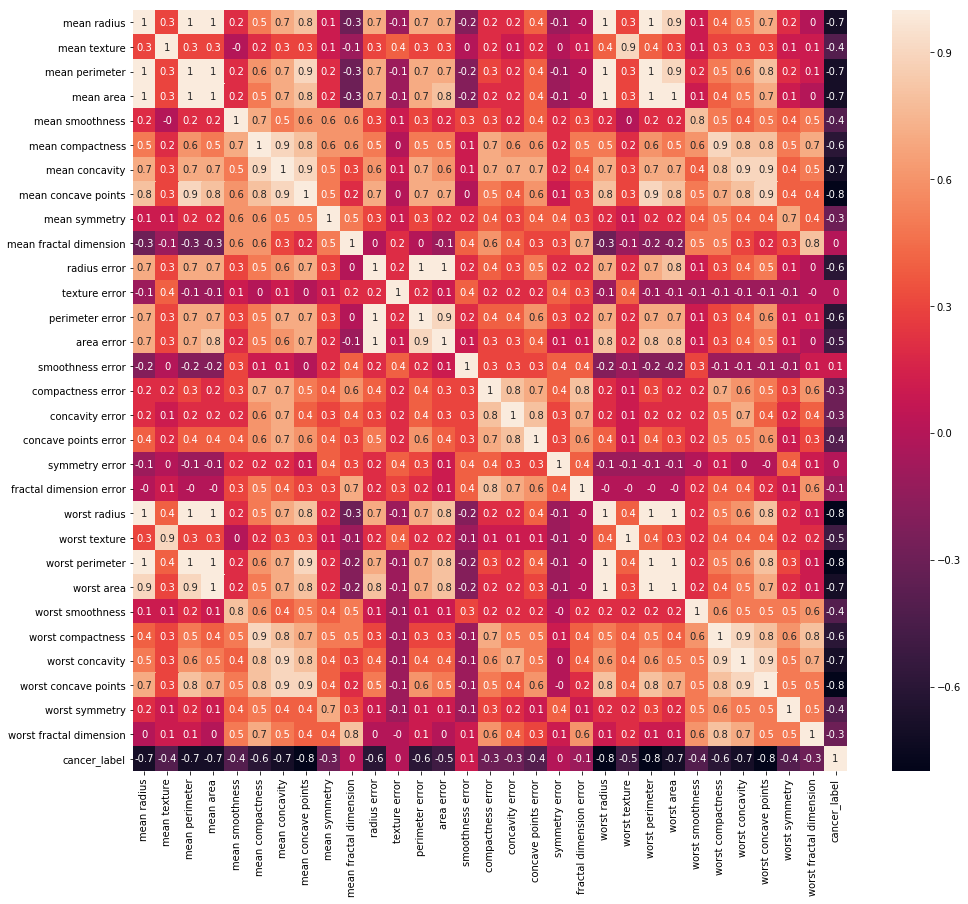

In [27]:

correlation_matrix = data.corr().round(1)
fig, ax = plt.subplots(figsize=(16,14))
sb.heatmap(data=correlation_matrix, annot = True)


In [28]:
features_original = breast_cancer_data['feature_names']

In [34]:
features = []
for f in features_original:
    if 'error' in f: continue
    features.append(f)

In [35]:
features

['mean radius',
 'mean texture',
 'mean perimeter',
 'mean area',
 'mean smoothness',
 'mean compactness',
 'mean concavity',
 'mean concave points',
 'mean symmetry',
 'mean fractal dimension',
 'worst radius',
 'worst texture',
 'worst perimeter',
 'worst area',
 'worst smoothness',
 'worst compactness',
 'worst concavity',
 'worst concave points',
 'worst symmetry',
 'worst fractal dimension']

In [45]:
feature_map = {feature: idx for idx, feature in enumerate(features)}
e4 = 'verdaderos_positivos'
e3 = 'falsos_positivos'
e2 = 'falsos_negativos'
e1 = 'verdaderos_negativos'

penalties = ['None','l1','l2', 'elasticnet']

iterations = [10,100,1000]
alphas = [1e-5,1e-3,1e-1,1e1]
columnas = ['fx','fy','penalty','alpha','iter','ee','ev',e1,e2,e3,e4]
dtCB = pd.DataFrame(columns=columnas)


for fx in features:
    x_feature = fx 
    print('\n\n\n\n******** ',x_feature)
    for fy in list(set(features)-set([fx])):
        print('-',fy)
        y_feature = fy
        
        x_feature_col = feature_map[x_feature]
        y_feature_col = feature_map[y_feature]
        X_train_feature = X_train[:, [x_feature_col, y_feature_col]]
        X_val_feature = X_val[:, [x_feature_col, y_feature_col]]

        for p in penalties:
            penalty = p
            for a in alphas:
                alpha = a
                for it in iterations:
                    max_iter = it
            
                    model = Perceptron(penalty=penalty, alpha=alpha, max_iter=max_iter)
                    model.fit(X_train_feature, y_train)
            
                    ee=accuracy_score(y_train, model.predict(X_train_feature))
                    ev=accuracy_score(y_val, model.predict(X_val_feature))
                    #print('Exactitud para entrenamiento: %.2f' %  ee)
                    #print('Exactitud para validación: %.2f' % ev)
                    
                    matriz = confusion_matrix(y_train, model.predict(X_train_feature))
                               
                    dtCB = dtCB.append({'fx':fx,'fy':fy,'penalty':penalty,'alpha':alpha,'iter':max_iter,
                                        'ee':ee,'ev':ev,e1:matriz[0][0],e2:matriz[0][1],
                                        e3:matriz[1][0],e4:matriz[1][1]},ignore_index=True)





********  mean radius
- mean smoothness
- worst symmetry
- mean compactness
- worst texture
- mean perimeter
- worst concave points
- mean concavity
- mean fractal dimension
- worst radius
- worst compactness
- worst concavity
- worst perimeter
- mean symmetry
- mean texture
- worst smoothness
- worst area
- worst fractal dimension
- mean concave points
- mean area




********  mean texture
- mean smoothness
- worst symmetry
- mean compactness
- worst texture
- mean perimeter
- worst concave points
- mean concavity
- mean fractal dimension
- mean radius
- worst radius
- worst compactness
- worst concavity
- worst perimeter
- mean symmetry
- worst smoothness
- worst area
- worst fractal dimension
- mean concave points
- mean area




********  mean perimeter
- mean smoothness
- worst symmetry
- mean compactness
- worst texture
- worst concave points
- mean concavity
- mean fractal dimension
- mean radius
- worst radius
- worst compactness
- worst concavity
- worst perimeter
- mean 

In [46]:
dtCB

,fx,fy,penalty,alpha,iter,ee,ev,verdaderos_negativos,falsos_negativos,falsos_positivos,verdaderos_positivos
0,mean radius,mean smoothness,None,0.00001,10,0.3675,0.390533,146,0,253,1
1,mean radius,mean smoothness,None,0.00001,100,0.7750,0.781065,138,8,82,172
2,mean radius,mean smoothness,None,0.00001,1000,0.8350,0.863905,130,16,50,204
3,mean radius,mean smoothness,None,0.00100,10,0.3675,0.390533,146,0,253,1
4,mean radius,mean smoothness,None,0.00100,100,0.7750,0.781065,138,8,82,172
5,mean radius,mean smoothness,None,0.00100,1000,0.8350,0.863905,130,16,50,204
6,mean radius,mean smoothness,None,0.10000,10,0.3675,0.390533,146,0,253,1
7,mean radius,mean smoothness,None,0.10000,100,0.7750,0.781065,138,8,82,172
8,mean radius,mean smoothness,None,0.10000,1000,0.8350,0.863905,130,16,50,204
9,mean radius,mean smoothness,None,10.00000,10,0.3675,0.390533,146,0,253,1


In [47]:
dtCB.to_csv(r'clasificacion_cancer.csv',index=None,header=True,sep='|')

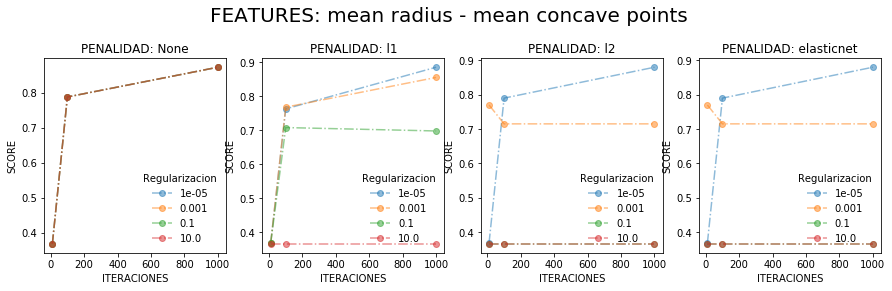

In [184]:
fig=plt.figure(figsize=(15,4))
fx = 'mean radius'
fy = 'mean concave points'

fig.suptitle('FEATURES: '+fx+' - '+fy , fontsize=20)
j=1
ls=['--',':','-.','-']


for p in penalties:
    plt.subplot(1,4,j)
    sub=dtCB[(dtCB.penalty==p)&(dtCB.fx==fx)&(dtCB.fy==fy)]
    for a in alphas:
        plt.plot(sub[sub.alpha==a].iter.values,sub[sub.alpha==a].ee.values,label=str(a),marker='o',ls='-.',alpha=0.5)
    plt.legend(title='Regularizacion',frameon=False,loc='lower right')
    plt.title('PENALIDAD: ' + p)
    plt.xlabel('ITERACIONES')
    plt.ylabel('SCORE')
    j+=1

plt.subplots_adjust(wspace=0.2, top=0.8)

Se puede observar que la penalidad l1, es la única que permite diferenciar los distintos valores que toma el hiperparámetro de regularización para las tres números de iteraciones en estudio., por otro lado se observa que mientras menor es alpha y mayor es el número de iteraciones, la exactidu aumenta, tanto al no considerar penalidad como al tomar la penalidad l1, lo mismo no sucede para la norma al cuadrado o la combinación lineal de ambos tipos (l1,l2)

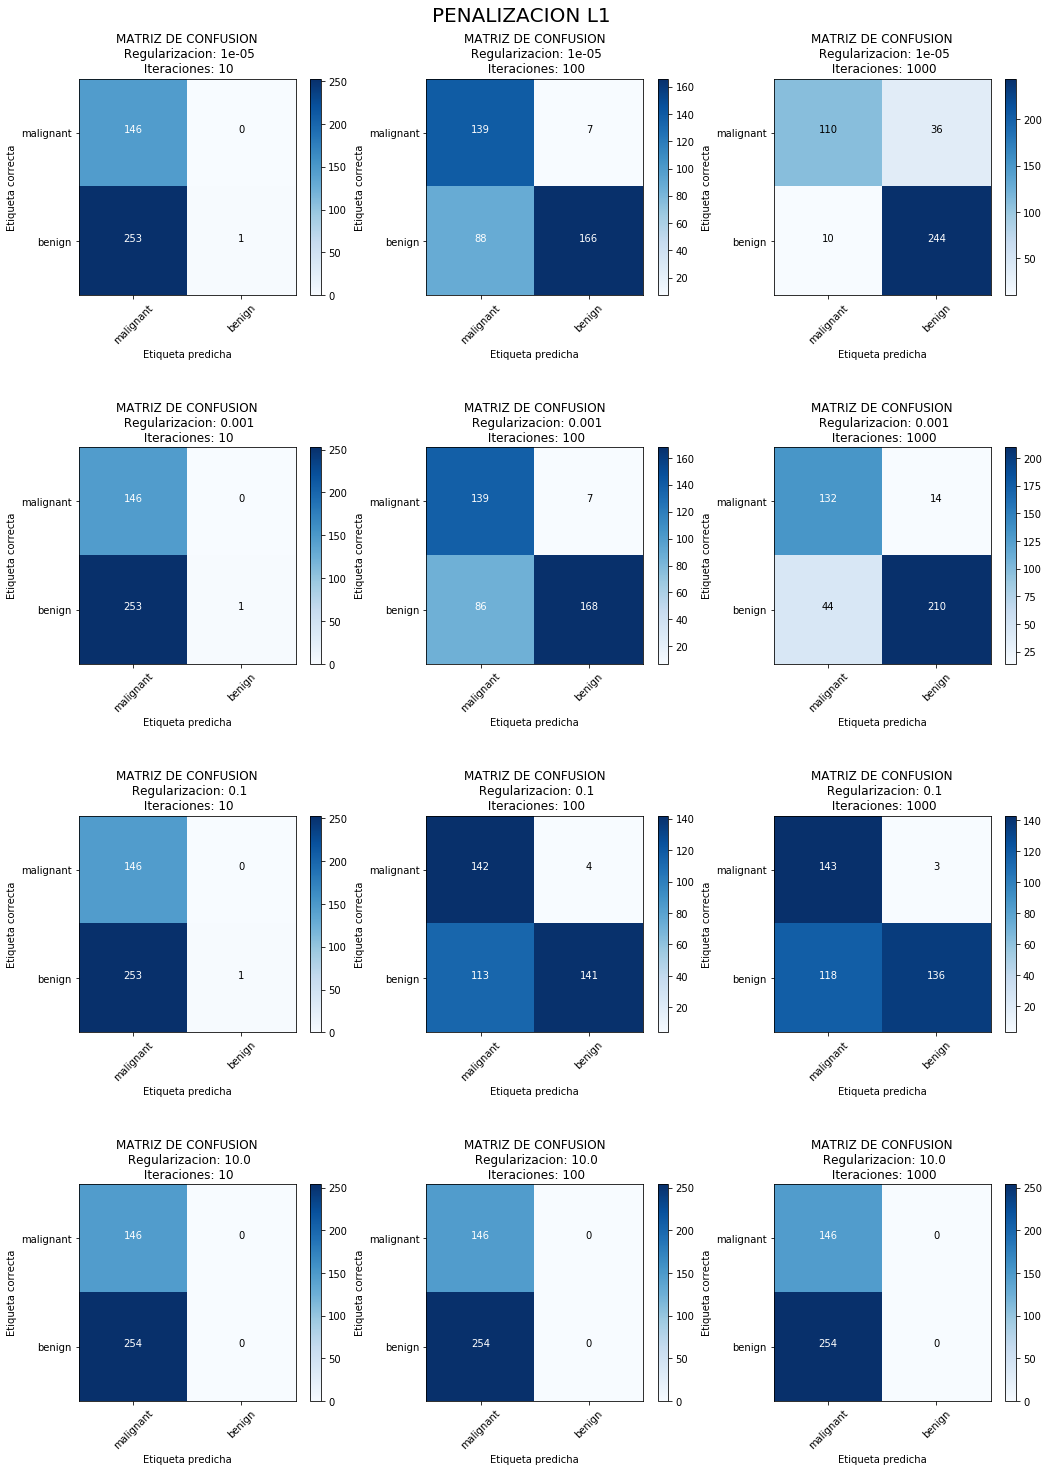

In [185]:
sub=dtCB[(dtCB.penalty=='l1')&(dtCB.fx==fx)&(dtCB.fy==fy)]
fig = plt.figure(figsize=(15,20))
fig.suptitle('PENALIZACION L1', fontsize=20)
for i in range(len(sub)):
    plt.subplot(4,3,i+1)
    matriz=np.array([[sub.verdaderos_negativos.values[i],sub.falsos_negativos.values[i]],
        [sub.falsos_positivos.values[i],sub.verdaderos_positivos.values[i]]])
    plot_confusion_matrix(matriz,classes=breast_cancer_data.target_names,
    title='MATRIZ DE CONFUSION\n Regularizacion: '+str(sub.alpha.values[i])+'\n Iteraciones: '+ str(sub.iter.values[i]))
plt.subplots_adjust( wspace=0.2, top=0.93, hspace=0.7)

Lo óptimo es minimizar los casos: etiqueta true diagnóstico false, es decir, cancer positivo, diagnóstico o predicción negativa.
    En el caso de penalidad L1, se puede ver que cuando alpha es muy chico, si bien se observó que la exactitud aumenta, también lo hacen los casos de falsos negativos cuando crece el número de iteraciones, lo cual no es bueno. Lo que se quiere decir, es que el análisis no es trivial y requiere de mucho estudio y de optar por la solución de compromisa más óptima. Tampoco se puede aceptar que el caso de nulidad del número de falsos negativos, pues como se puede ver en la matriz de confusión, tales predicciones conllevan una gran inexactitud, ya que no se predice ningún tumor benigno. 
    

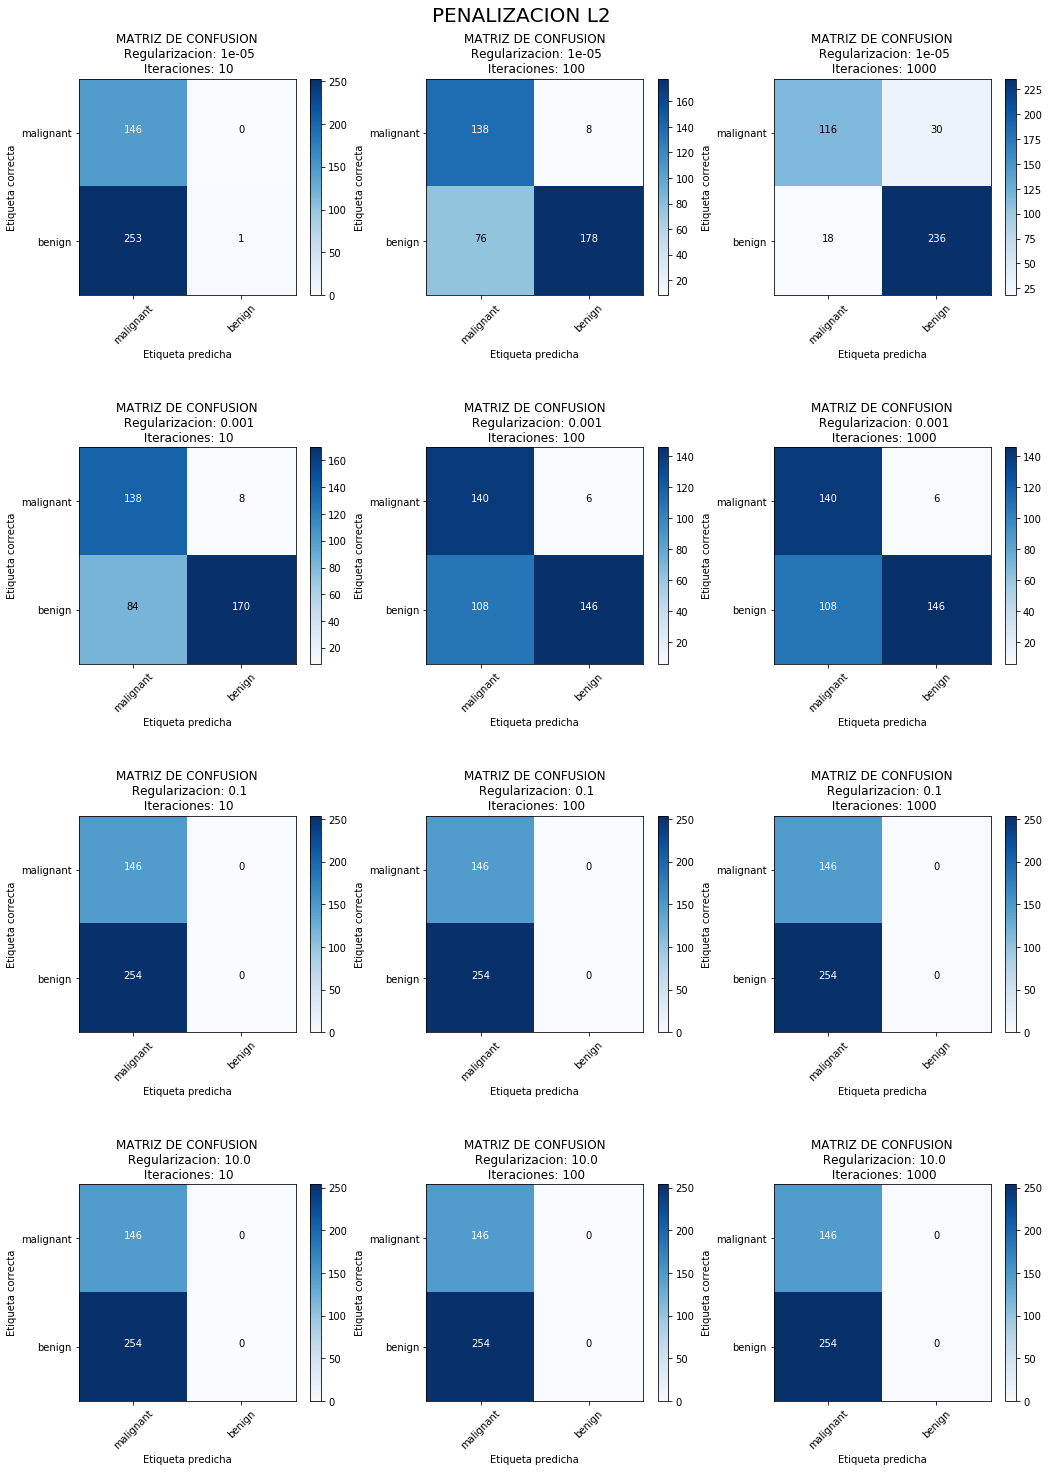

In [186]:
sub=dtCB[(dtCB.penalty=='l2')&(dtCB.fx==fx)&(dtCB.fy==fy)]
fig = plt.figure(figsize=(15,20))
fig.suptitle('PENALIZACION L2', fontsize=20)
for i in range(len(sub)):
    plt.subplot(4,3,i+1)
    matriz=np.array([[sub.verdaderos_negativos.values[i],sub.falsos_negativos.values[i]],
        [sub.falsos_positivos.values[i],sub.verdaderos_positivos.values[i]]])
    plot_confusion_matrix(matriz,classes=breast_cancer_data.target_names,
    title='MATRIZ DE CONFUSION\n Regularizacion: '+str(sub.alpha.values[i])+'\n Iteraciones: '+ str(sub.iter.values[i])) 
plt.subplots_adjust( wspace=0.2, top=0.93, hspace=0.7)

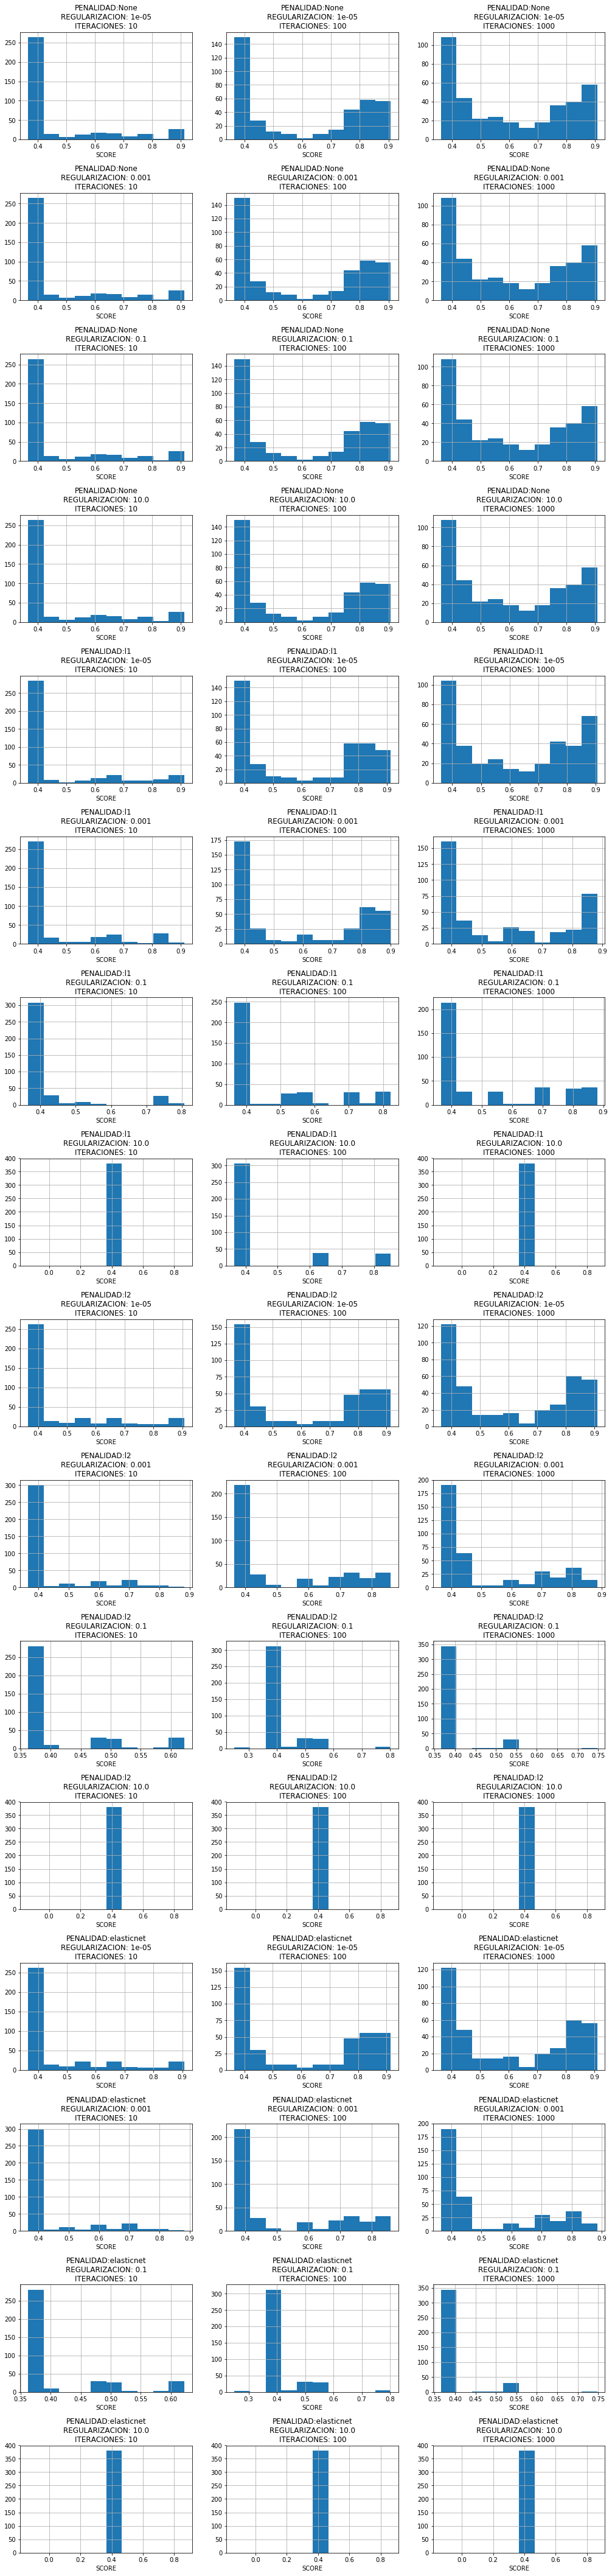

In [187]:
fig = plt.figure(figsize=(15,20))
j=1
for p in penalties:
    for a in alphas:
        for i in iterations:
            plt.subplot(16,3,j)
            dtCB[(dtCB.iter==i)&(dtCB.penalty==p)&(dtCB.alpha==a)].ee.hist()
            #plt.title('MATRIZ DE CONFUSION\n Regularizacion: '+str(sub.alpha.values[i])+'\n Iteraciones: '+ str(sub.iter.values[i])
            plt.title('PENALIDAD:'+str(p)+'\nREGULARIZACION: '+str(a)+'\nITERACIONES: '+str(i))
            plt.xlabel('SCORE')
            j+=1
            
plt.subplots_adjust(left=0.01, wspace=0.2, top=3, hspace=0.5)            

Los histogramas de exactitud en función de alpha, tipo de penalidad y número de iteraciones muestran:
1. la exactitud tiende a mejorar a partir de 100 iteraciones
2. la penalidad de tipo L1 parece mejor que el resto de las penalidades
3. regularizaciones más chicas implican mayor exactitud 

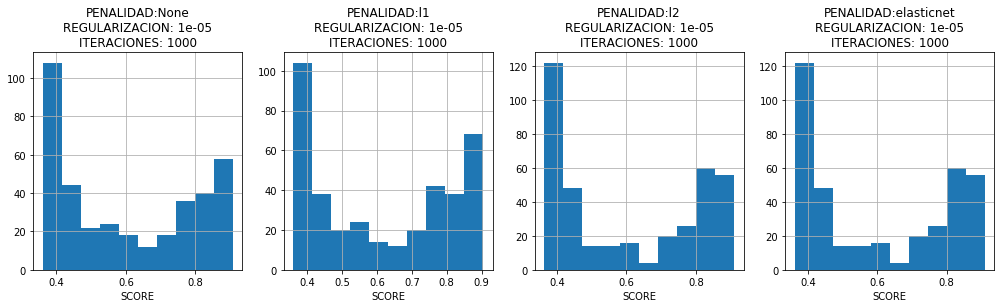

In [188]:
fig = plt.figure(figsize=(15,4))
j=1
for p in penalties:
    plt.subplot(1,4,j)
    dtCB[(dtCB.iter==1000)&(dtCB.penalty==p)&(dtCB.alpha==1e-5)].ee.hist()
    #plt.title('MATRIZ DE CONFUSION\n Regularizacion: '+str(sub.alpha.values[i])+'\n Iteraciones: '+ str(sub.iter.values[i])
    plt.title('PENALIDAD:'+str(p)+'\nREGULARIZACION: '+str(1e-5)+'\nITERACIONES: '+str(1000))
    plt.xlabel('SCORE')
    j+=1
            
plt.subplots_adjust(left=0.01, wspace=0.2)     

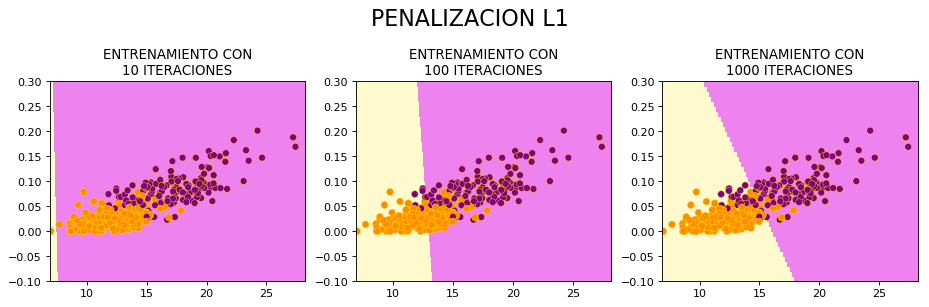

In [191]:
x_feature = fx
y_feature = fy

x_feature_col = feature_map[x_feature]
y_feature_col = feature_map[y_feature]
X_train_feature = X_train[:, [x_feature_col, y_feature_col]]
X_val_feature = X_val[:, [x_feature_col, y_feature_col]]

penalty = 'l1'
alpha = 1e-5 
j=1

fig=plt.figure(figsize=(14, 4), dpi=80, facecolor='w', edgecolor='k')
fig.suptitle('PENALIZACION L1', fontsize=20)
for i in iterations:
    max_iter = i
    model = Perceptron(penalty=penalty, alpha=alpha, max_iter=max_iter)
    model.fit(X_train_feature, y_train)
    
    xx, yy, Z = classifier_boundary(np.r_[X_train_feature, X_val_feature], model)
    
    cmap_dots = ListedColormap(['purple', 'darkorange'])
    cmap_edge = ListedColormap(['darkviolet', 'gold'])
    cmap_back = ListedColormap(['violet', 'lemonchiffon'])
    
    # Conjunto de entrenamiento
    plt.subplot(1, 3,j)
    plt.pcolormesh(xx, yy, Z, cmap=cmap_back)
    plt.scatter(X_train_feature[:, 0], X_train_feature[:, 1], c=y_train, cmap=cmap_dots, edgecolor='gold',lw=0.4, s=38)
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())
    plt.title('ENTRENAMIENTO CON\n'+str(i)+' ITERACIONES')
    
    j+=1
plt.subplots_adjust( top=0.75)    

Se observa una gran mejora de la caracterización de la frontera a medida que aumenta el número de iteraciones, al menos, dentro de los tres valores, del número iteraciones, considerados

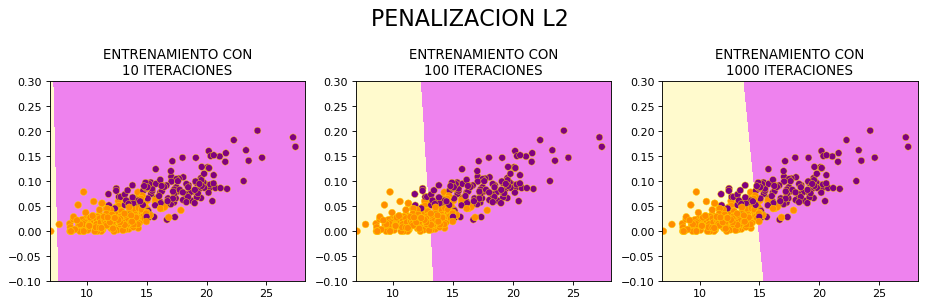

In [192]:
x_feature = fx
y_feature = fy

x_feature_col = feature_map[x_feature]
y_feature_col = feature_map[y_feature]
X_train_feature = X_train[:, [x_feature_col, y_feature_col]]
X_val_feature = X_val[:, [x_feature_col, y_feature_col]]

penalty = 'l2'
alpha = 1e-5 
j=1

fig=plt.figure(figsize=(14, 4), dpi=80, facecolor='w', edgecolor='k')
fig.suptitle('PENALIZACION L2', fontsize=20)
for i in iterations:
    max_iter = i
    model = Perceptron(penalty=penalty, alpha=alpha, max_iter=max_iter)
    model.fit(X_train_feature, y_train)
    
    xx, yy, Z = classifier_boundary(np.r_[X_train_feature, X_val_feature], model)
    
    cmap_dots = ListedColormap(['purple', 'darkorange'])
    cmap_edge = ListedColormap(['darkviolet', 'gold'])
    cmap_back = ListedColormap(['violet', 'lemonchiffon'])
    
    # Conjunto de entrenamiento
    plt.subplot(1, 3,j)
    plt.pcolormesh(xx, yy, Z, cmap=cmap_back)
    plt.scatter(X_train_feature[:, 0], X_train_feature[:, 1], c=y_train, cmap=cmap_dots, edgecolor='gold',lw=0.4, s=38)
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())
    plt.title('ENTRENAMIENTO CON\n'+str(i)+' ITERACIONES')
    
    j+=1
plt.subplots_adjust( top=0.75)    


# VECINOS MAS CERCANOS

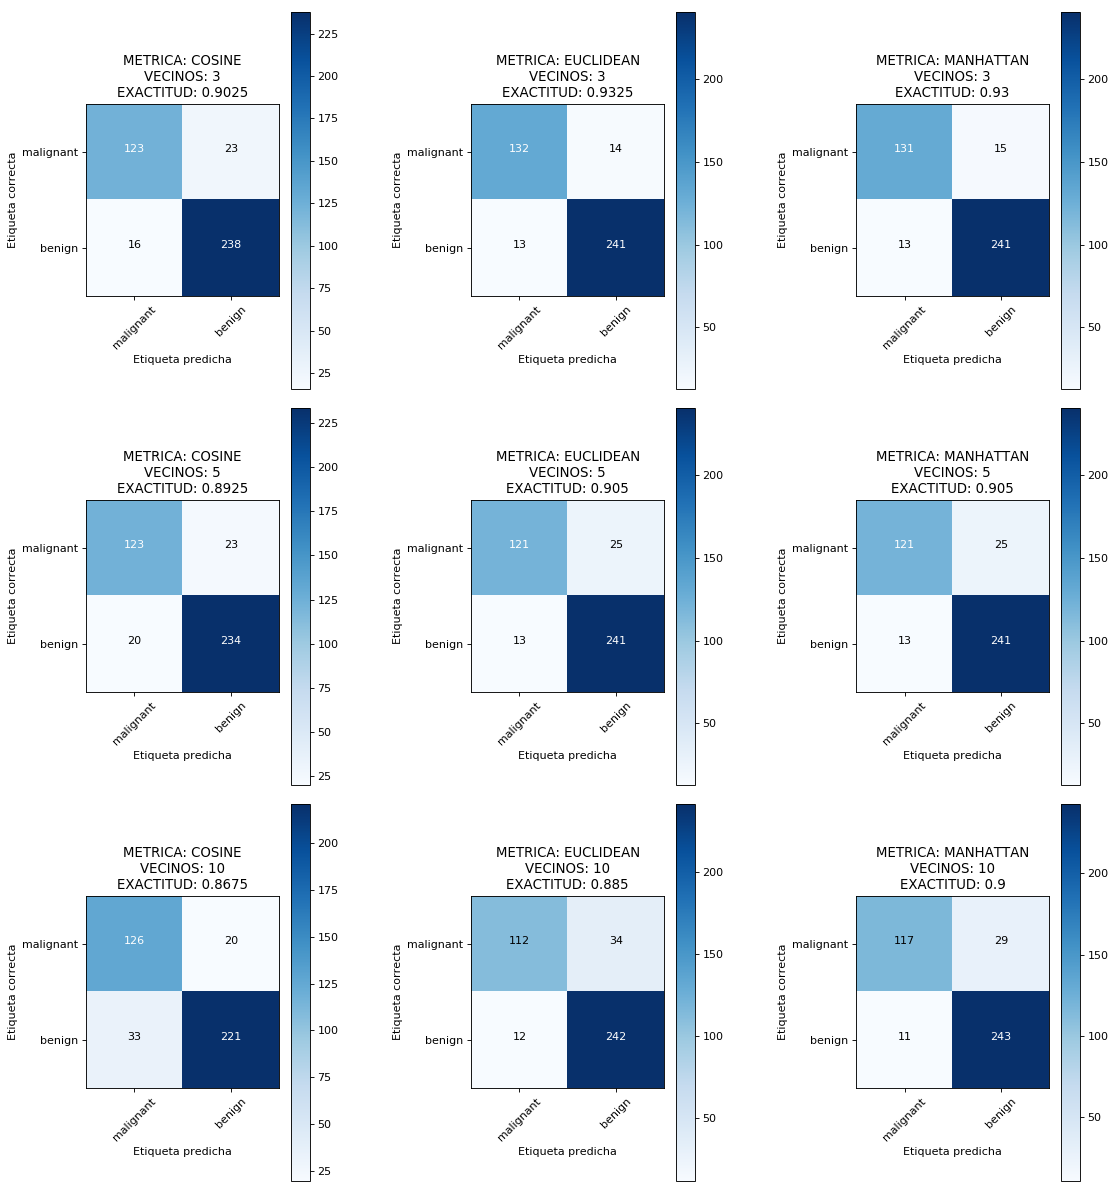

In [209]:
neighbors = [3,5,10] 
metricas = ['cosine','euclidean','manhattan']

plt.figure(figsize=(14,15), dpi= 80, facecolor='w', edgecolor='k')
j=1
for n in neighbors:
    for m in metricas:
        n_neighbors=n
        metric = m 
        model = KNeighborsClassifier(n_neighbors=n_neighbors, metric=metric)
        model.fit(X_train_feature, y_train)
    
        exactitud = accuracy_score(y_train, model.predict(X_train_feature))
    
        plt.subplot(3, 3, j)
        plot_confusion_matrix(confusion_matrix(y_train, model.predict(X_train_feature)),
                      classes=breast_cancer_data.target_names,
                      title='METRICA: '+m.upper()+'\nVECINOS: '+str(n)+'\nEXACTITUD: '+str(exactitud))
        j+=1
plt.subplots_adjust( wspace=0.6)  

Se observa que para el menor número de vecinos considerado, la métrica euclídea muetsra la mejor exactitud y la menor cantidad de casos falsos negativos, sin embargo, para 10 vecinos es la métrica manhattan la que otorga los mejores predicciones

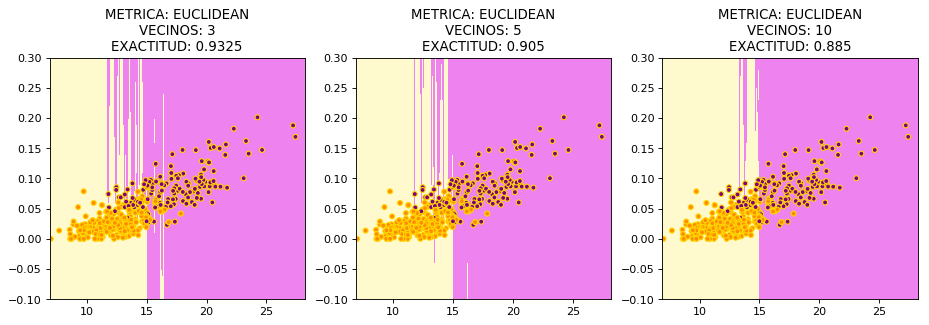

In [215]:
plt.figure(figsize=(14,4), dpi= 80, facecolor='w', edgecolor='k')
j=1
for n in neighbors:
    for m in metricas:
        if m!='euclidean':continue
        n_neighbors=n
        metric = m 
        model = KNeighborsClassifier(n_neighbors=n_neighbors, metric=metric)
        model.fit(X_train_feature, y_train)
    
        exactitud = accuracy_score(y_train, model.predict(X_train_feature))
    
        plt.subplot(1, 3, j)

        xx, yy, Z = classifier_boundary(np.r_[X_train_feature, X_val_feature], model)
        plt.pcolormesh(xx, yy, Z, cmap=cmap_back)
        plt.scatter(X_train_feature[:, 0], X_train_feature[:, 1], c=y_train, cmap=cmap_dots, edgecolor='gold', s=20)
        plt.xlim(xx.min(), xx.max())
        plt.ylim(yy.min(), yy.max())
        plt.title('METRICA: '+m.upper()+'\nVECINOS: '+str(n)+'\nEXACTITUD: '+str(exactitud))

        j+=1

# CLASIFICACION MULTICLASE

In [2]:
iris_data = load_iris()

shuff_data = np.random.permutation(150)
shuff_train = shuff_data[:120]
shuff_val = shuff_data[120:]

X_train = iris_data['data'][shuff_train]
X_val = iris_data['data'][shuff_val]

y_train = iris_data['target'][shuff_train]
y_val = iris_data['target'][shuff_val]

feature_map = {feature: idx for idx, feature in enumerate(iris_data['feature_names'])}

print(iris_data['DESCR'])

.. _iris_dataset:

Iris plants dataset
--------------------

**Data Set Characteristics:**

    :Number of Instances: 150 (50 in each of three classes)
    :Number of Attributes: 4 numeric, predictive attributes and the class
    :Attribute Information:
        - sepal length in cm
        - sepal width in cm
        - petal length in cm
        - petal width in cm
        - class:
                - Iris-Setosa
                - Iris-Versicolour
                - Iris-Virginica
                
    :Summary Statistics:

    ============== ==== ==== ======= ===== ====================
                    Min  Max   Mean    SD   Class Correlation
    ============== ==== ==== ======= ===== ====================
    sepal length:   4.3  7.9   5.84   0.83    0.7826
    sepal width:    2.0  4.4   3.05   0.43   -0.4194
    petal length:   1.0  6.9   3.76   1.76    0.9490  (high!)
    petal width:    0.1  2.5   1.20   0.76    0.9565  (high!)
    ============== ==== ==== ======= ===== ===========

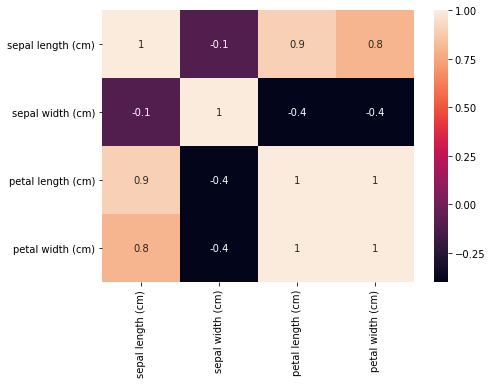

In [6]:
data = pd.DataFrame(iris_data['data'],columns=iris_data['feature_names'])
iris_data['iris_label'] = iris_data['target']
correlation_matrix = data.corr().round(1)
fig, ax = plt.subplots(figsize=(7,5))
sb.heatmap(data=correlation_matrix, annot = True)

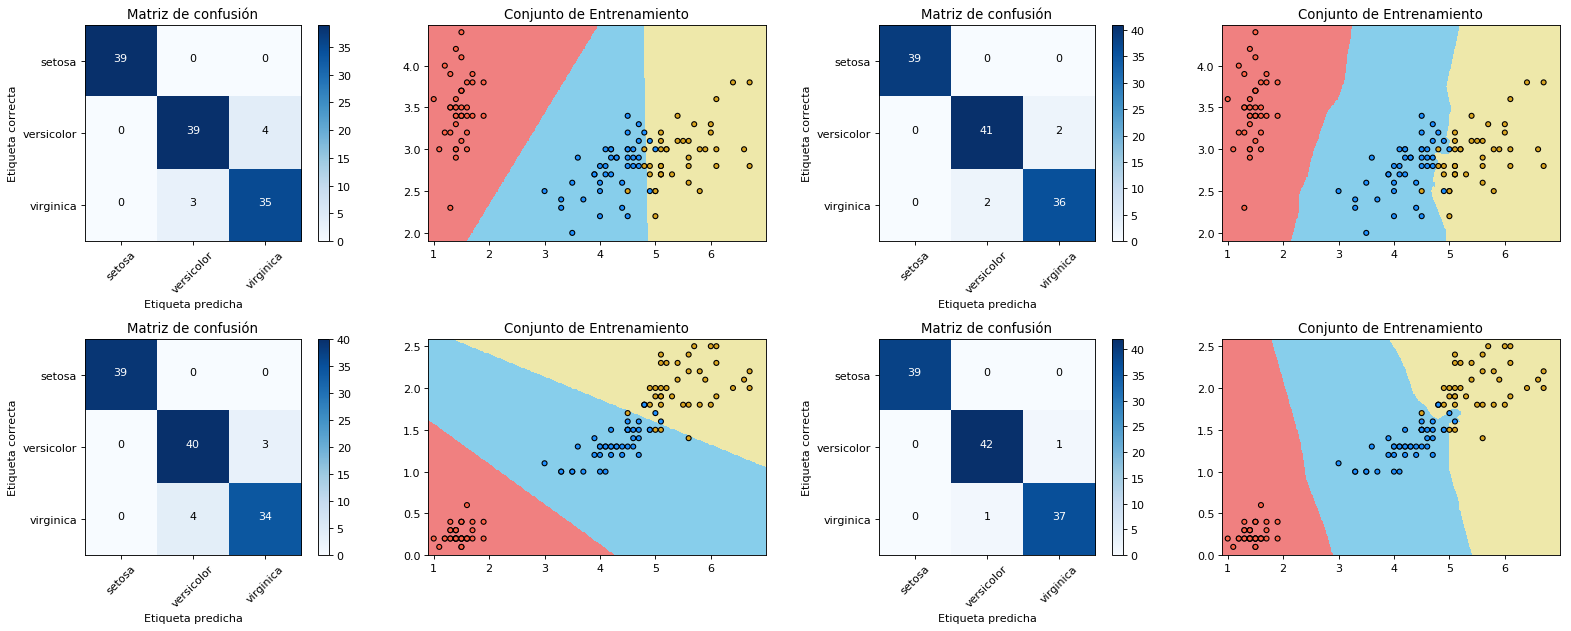

In [17]:
x_feature = 'petal length (cm)'
y_features = ['sepal width (cm)','petal width (cm)']
penalties=['l1','l2']
alphas=[1e-5,1e1]

cmap_dots = ListedColormap(['tomato', 'dodgerblue', 'goldenrod'])
cmap_back = ListedColormap(['lightcoral', 'skyblue', 'palegoldenrod'])
  
    
plt.figure(figsize=(20, 8), dpi= 80, facecolor='w', edgecolor='k')    
j=0    
for yf in y_features:
    y_feature = yf

    x_feature_col = feature_map[x_feature]
    y_feature_col = feature_map[y_feature]
    X_train_feature = X_train[:, [x_feature_col, y_feature_col]]
    X_val_feature = X_val[:, [x_feature_col, y_feature_col]]
    
    for p in penalties:
        if p!=penalties[0]:continue
        penalty = p
        for a in alphas:
            if a!= alphas[0]:continue
            alpha = a
            model = LogisticRegression(penalty=penalty, C=1./alpha, multi_class='ovr')
            model.fit(X_train_feature, y_train)
            exactitud = accuracy_score(y_train, model.predict(X_train_feature))
            
            plt.subplot(2, 4, 1+j*4)
            plot_confusion_matrix(confusion_matrix(y_train, model.predict(X_train_feature)),
                              classes=iris_data.target_names,
                              title='Matriz de confusión')
        
        
            xx, yy, Z = classifier_boundary(np.r_[X_train_feature, X_val_feature], model)
        

            plt.subplot(2, 4, 2+j*4)
            plt.pcolormesh(xx, yy, Z, cmap=cmap_back)
            plt.scatter(X_train_feature[:, 0], X_train_feature[:, 1], c=y_train, cmap=cmap_dots, edgecolor='k', s=20)
            plt.xlim(xx.min(), xx.max())
            plt.ylim(yy.min(), yy.max())
            plt.title("Conjunto de Entrenamiento")
            
            
            
            n_neighbors = 3 # TODO: Cantidad de vecinos a tener en cuenta
            metric = 'euclidean' # TODO: Medida de distancia. Algunas opciones: cosine, euclidean, manhattan.
            
            
                                       
            model = KNeighborsClassifier(n_neighbors=n_neighbors, metric=metric)
            model.fit(X_train_feature, y_train)
                                       
            exactitud =accuracy_score(y_train, model.predict(X_train_feature))

            
            plt.subplot(2, 4, 3+j*4)
            plot_confusion_matrix(confusion_matrix(y_train, model.predict(X_train_feature)),
                                  classes=iris_data.target_names,
                                  title='Matriz de confusión')
            
            
            xx, yy, Z = classifier_boundary(np.r_[X_train_feature, X_val_feature], model)
            
            cmap_dots = ListedColormap(['tomato', 'dodgerblue', 'goldenrod'])
            cmap_back = ListedColormap(['lightcoral', 'skyblue', 'palegoldenrod'])
            
            plt.subplot(2, 4, 4+j*4)
            plt.pcolormesh(xx, yy, Z, cmap=cmap_back)
            plt.scatter(X_train_feature[:, 0], X_train_feature[:, 1], c=y_train, cmap=cmap_dots, edgecolor='k', s=20)
            plt.xlim(xx.min(), xx.max())
            plt.ylim(yy.min(), yy.max())
            plt.title("Conjunto de Entrenamiento")
                                      
    j+=1

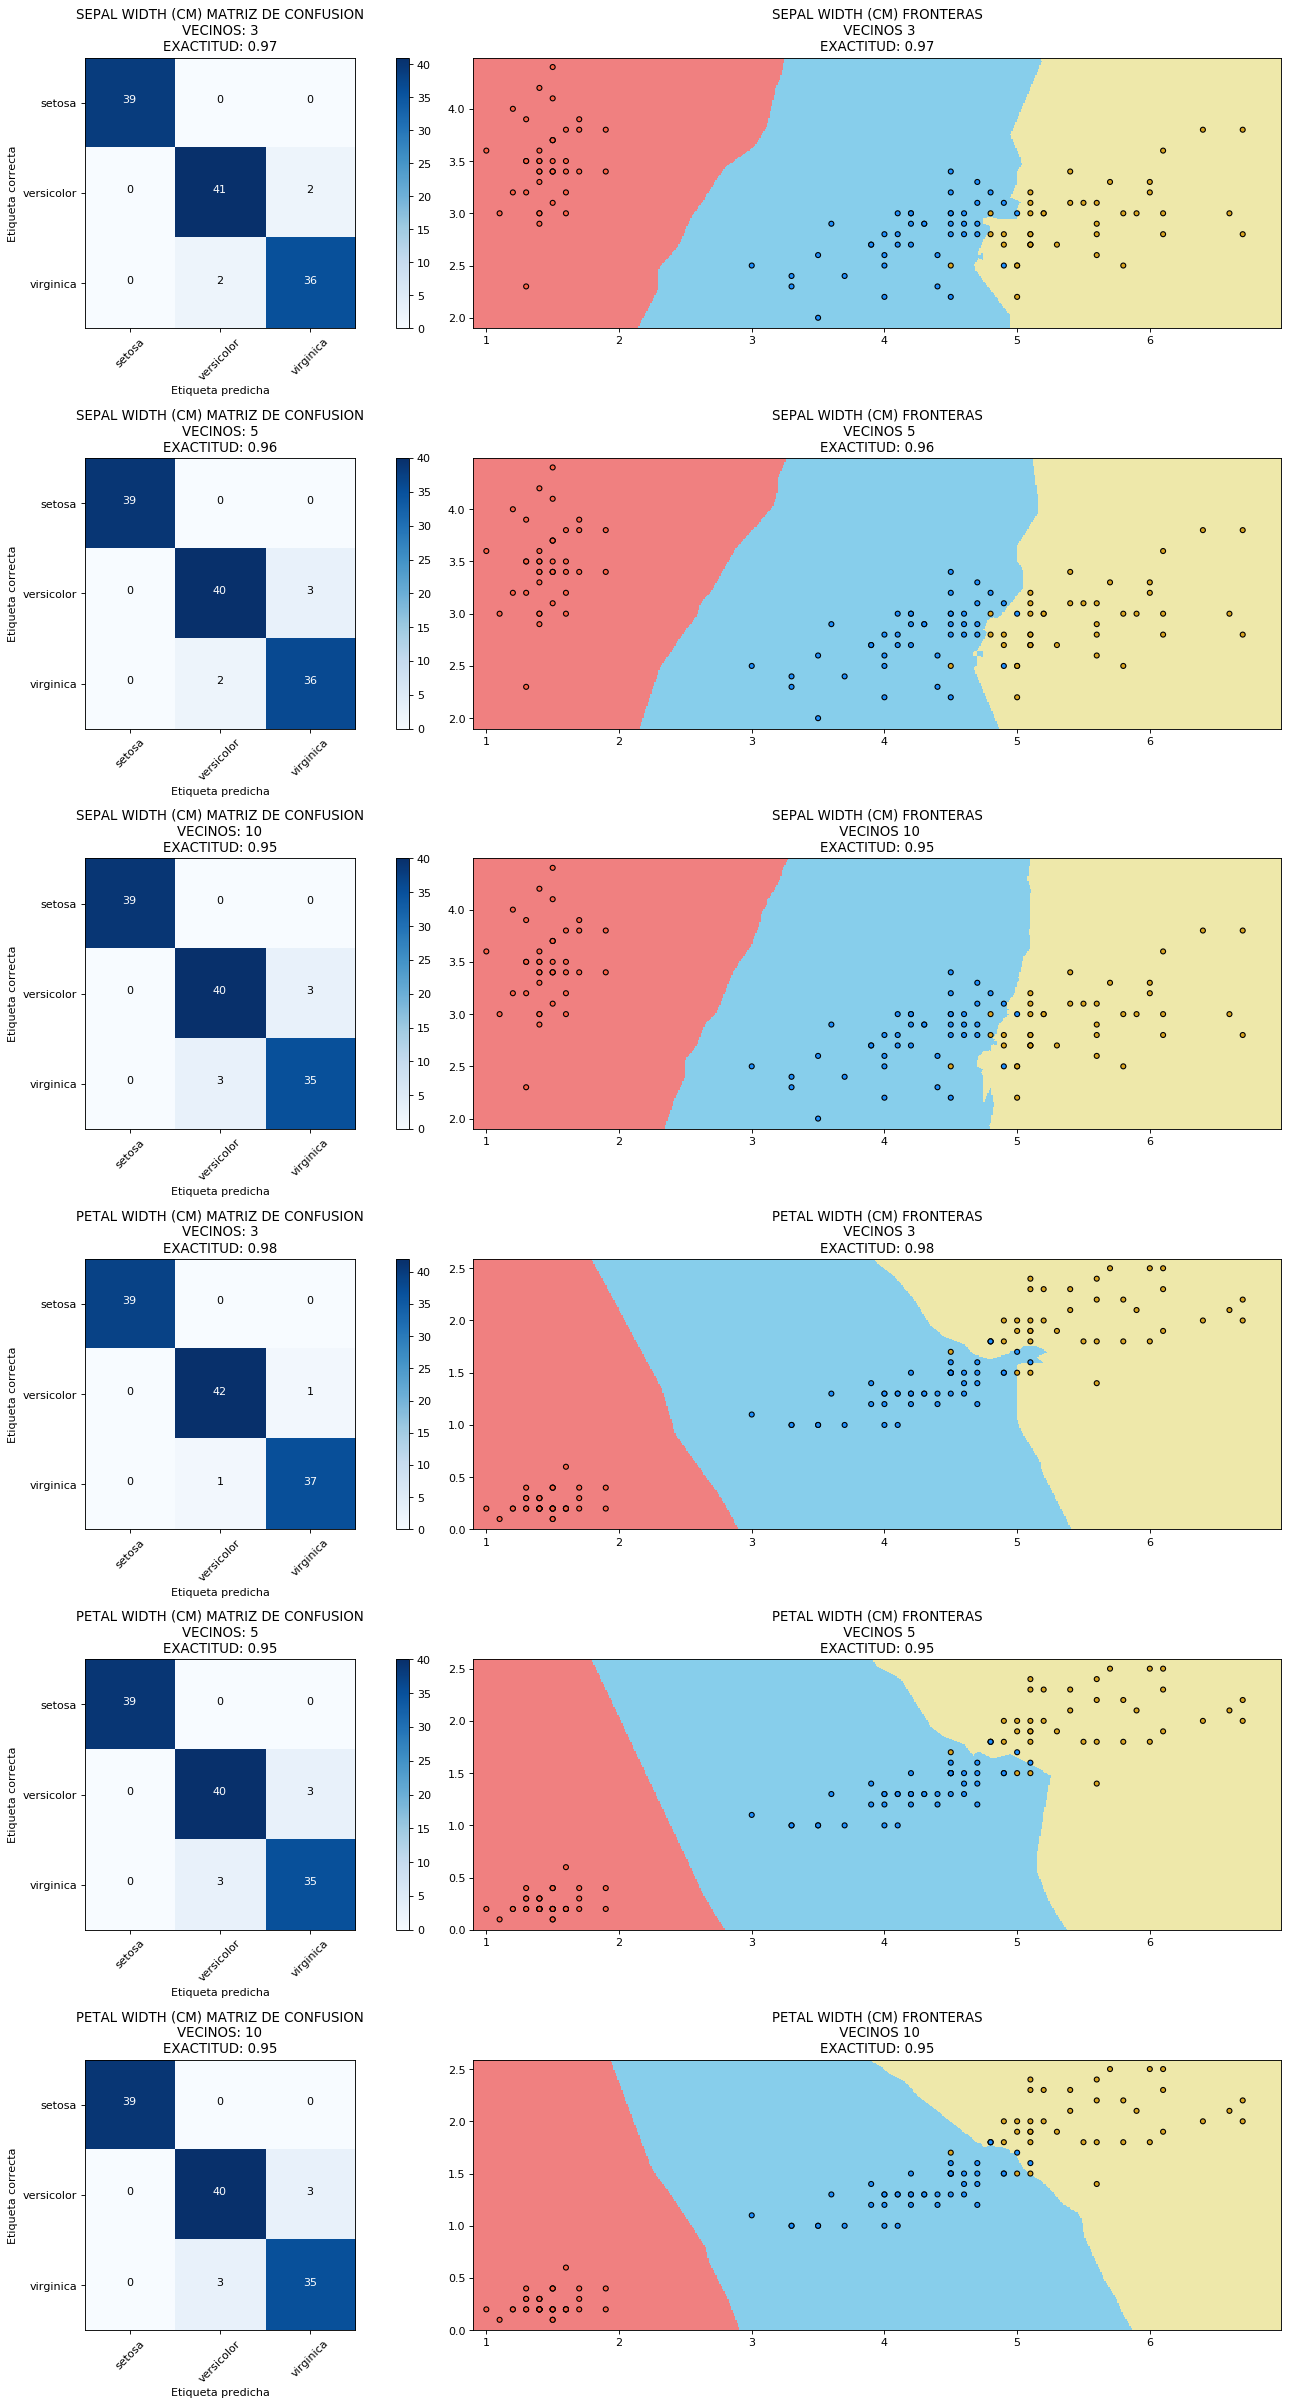

In [24]:
x_feature = 'petal length (cm)'
y_features = ['sepal width (cm)','petal width (cm)']
penalties=['l1','l2']
alphas=[1e-5,1e1]

cmap_dots = ListedColormap(['tomato', 'dodgerblue', 'goldenrod'])
cmap_back = ListedColormap(['lightcoral', 'skyblue', 'palegoldenrod'])
  
    
plt.figure(figsize=(20, 30), dpi= 80, facecolor='w', edgecolor='k')
fig.suptitle('x_feature: '+x_feature.upper(), fontsize=20)
j=0    
for yf in y_features:
   
    y_feature = yf

    x_feature_col = feature_map[x_feature]
    y_feature_col = feature_map[y_feature]
    X_train_feature = X_train[:, [x_feature_col, y_feature_col]]
    X_val_feature = X_val[:, [x_feature_col, y_feature_col]]
    
    for p in penalties:
        if p!=penalties[0]:continue
        penalty = p
        for a in alphas:
            if a!= alphas[0]:continue
            alpha = a
            model = LogisticRegression(penalty=penalty, C=1./alpha, multi_class='ovr')
            model.fit(X_train_feature, y_train)
            
            i=1
            for n in neighbors:
                n_neighbors = n 
                metric = 'euclidean'
                                   
                model = KNeighborsClassifier(n_neighbors=n_neighbors, metric=metric)
                model.fit(X_train_feature, y_train)
                                       
                exactitud = round(accuracy_score(y_train, model.predict(X_train_feature)),2)

            
                plt.subplot(6, 2, i+j*6)
                plot_confusion_matrix(confusion_matrix(y_train, model.predict(X_train_feature)),
                                  classes=iris_data.target_names,
                                  title=y_feature.upper()+' MATRIZ DE CONFUSION\nVECINOS: '+str(n)+'\nEXACTITUD: '+str(exactitud))
            
            
                xx, yy, Z = classifier_boundary(np.r_[X_train_feature, X_val_feature], model)
            
                cmap_dots = ListedColormap(['tomato', 'dodgerblue', 'goldenrod'])
                cmap_back = ListedColormap(['lightcoral', 'skyblue', 'palegoldenrod'])
            
                i+=1
                
                plt.subplot(6, 2, i+j*6)
                plt.pcolormesh(xx, yy, Z, cmap=cmap_back)
                plt.scatter(X_train_feature[:, 0], X_train_feature[:, 1], c=y_train, cmap=cmap_dots, edgecolor='k', s=20)
                plt.xlim(xx.min(), xx.max())
                plt.ylim(yy.min(), yy.max())
                plt.title(y_feature.upper()+' FRONTERAS\n VECINOS '+str(n)+'\nEXACTITUD: '+str(exactitud))
                
                i+=1
                                      
    j+=1

Si bien al considerar menos vecinos, la prediccón es mejor, puede verse que la predicción también depende de los features utilizados. En este caso se escogieron pares de features fuertemente correlacionados y se ve que al variar y_feature entre dos valores, cuando se tienen 3 vecinos, la exactitud varía en 0.01.